In [43]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pylab as plt
# import vision.sim_tools.connectors.kernel_connectors as kconn
from vision.spike_tools.vis import my_imshow, plot_spikes, \
                                   plot_output_spikes, \
                                   imgs_in_T_from_spike_array
# from vision.sim_tools.vis import plot_connector_3d
# import vision.sim_tools.kernels.center_surround as csgen
# import vision.sim_tools.kernels.gabor as gabgen

from mpl_toolkits.mplot3d import axes3d, Axes3D

from vision.retina import Retina, dvs_modes, MERGED
from vision.lgn import LGN
from vision.spike_tools.pattern import pattern_generator as pat_gen

# from pyNN import nest as sim
from pyNN import spiNNaker as sim

print(sim.__name__)


def setup_cam_pop(sim, spike_array, img_w, img_h, w2s=1.6):
    print("Setting up camera population...")
    pop_size = img_w*img_h*2
    cell = sim.IF_curr_exp
    params = { 'cm': 0.2,  # nF
               'i_offset': 0.0,
               'tau_m': 10.0,
               'tau_refrac': 2.0,
               'tau_syn_E': 1.,
               'tau_syn_I': 1.,
               'v_reset': -70.0,
               'v_rest': -65.0,
               'v_thresh': -55.4
             }
    dmy_pops = []
    dmy_prjs = []
    
    if sim.__name__ == 'pyNN.spiNNaker':
        cam_pop = sim.Population(pop_size, sim.SpikeSourceArray,
                                 {'spike_times': spike_array},
                                 label='camera')
    else:
        cam_pop = sim.Population(pop_size, cell, params,
                                 label='camera')
        for i in range(pop_size):
            dmy_pops.append(sim.Population(1, sim.SpikeSourceArray, 
                                           {'spike_times': spike_array[i]},
                                           label='pixel (row, col) = (%d, %d)'%\
                                           (i//img_w, i%img_w)))
            conn = [(0, i, w2s, 1)]
            dmy_prjs.append(sim.Projection(dmy_pops[i], cam_pop,
                                           sim.FromListConnector(conn),
                                           target='excitatory'))
    
    return cam_pop, dmy_pops, dmy_prjs



def plot_out_spikes(on_spikes, off_spikes, img_w, img_h, 
                    end_t_ms, ftime_ms, thresh, title):
    on_imgs = imgs_in_T_from_spike_array(on_spikes, img_w, img_h, 
                                         0, end_t_ms, ftime_ms, 
                                         out_array=True, thresh=thresh, 
                                         up_down=1)

    off_imgs = imgs_in_T_from_spike_array(off_spikes, img_w, img_h, 
                                          0, end_t_ms, ftime_ms, 
                                          out_array=True, thresh=thresh,
                                          up_down=0)

    num_imgs = len(on_imgs)
    cols = 5
    rows = num_imgs//cols + 1
    figw = 2
    fig = plt.figure(figsize=(figw*cols, figw*rows))
    for i in range(num_imgs):

        off_imgs[i][:,:,1] = on_imgs[i][:,:,1]
        
        ax = plt.subplot(rows, cols, i+1)
        my_imshow(ax, off_imgs[i], cmap=None)
    # plot_spikes(spikes)
    plt.suptitle(title)
    plt.show()

pyNN.spiNNaker


In [44]:
# img_w, img_h = 160, 128
# img_w, img_h = 80, 64
img_w, img_h = 40, 32
num_neurons = img_w*img_h*2
fps = 30
frames = 10#0
thresh = 25
deg = 135
dx = 1.
'''spikes_pol_MERGED_enc_RATE_
   thresh_25_hist_99_
   inh_False___
   64_frames_at_
   30fps_
   32x32_res_spikes
'''
on_time_ms  = int( frames*(1000./fps) )
ftime_ms    = int( 1000./fps )
off_time_ms = 0
start_time  = 10

2560


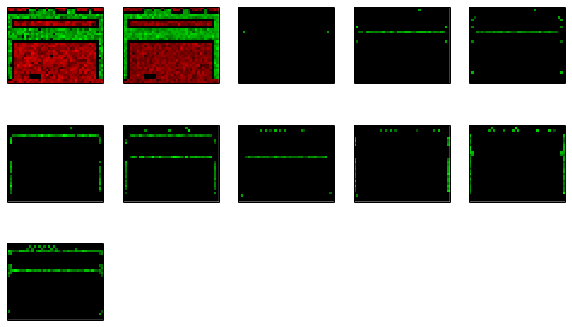

In [45]:
# spikes_dir = './moving_bar_spikes/deg_%d___dx_%f'%(deg, dx)
# spikes_dir = './breakout_emu_spikes'
# spikes_dir = './breakout_emu_spikes_80'
spikes_dir = './breakout_emu_spikes_40'
spikes = pat_gen.img_spikes_from_to(spikes_dir, num_neurons, 0, 1, 
                                    on_time_ms, off_time_ms,
                                    start_time)

print(len(spikes))
def img_map(nrn_id, img_width, img_height):
    cols_bits = np.uint8(np.ceil(np.log2(img_width)))
    cols_mask = int(2**cols_bits - 1)
    rows_bits = np.uint8(np.ceil(np.log2(img_height)))
    rows_mask = int(2**rows_bits - 1)

    col = (nrn_id >> (rows_bits + 1)) & cols_mask
    row = (nrn_id >> 1) & rows_mask
    up_dn = nrn_id & 1
    
    return row, col, up_dn

imgsU = imgs_in_T_from_spike_array(spikes, img_w, img_h, 
                                   0, on_time_ms, ftime_ms, 
                                   out_array=False, thresh=25,
                                   map_func=img_map)
# imgsD = imgs_in_T_from_spike_array(spikes[1:2*img_w*img_h:2], img_w, img_h, 
#                                    0, on_time_ms, ftime_ms, 
#                                    out_array=False, thresh=25)
num_imgs = len(imgsU)
cols = 5
rows = num_imgs//cols + 1
figw = 2
fig = plt.figure(figsize=(figw*cols, figw*rows))
for i in range(num_imgs):
#     out_img = np.zeros((img_h, img_w, 3), dtype=np.uint8)
#     out_img[:, :, 1] = imgsU[i]
#     out_img[:, :, 0] = imgsD[i]
    ax = plt.subplot(rows, cols, i+1)
#     my_imshow(ax, out_img, cmap=None)
    my_imshow(ax, imgsU[i], cmap=None)
# plot_spikes(spikes)
plt.savefig("test_input.png", dpi=150)
plt.show()

In [46]:
w2s = 1.7
sim.setup(timestep=1., max_delay=8., min_delay=1.)
if sim.__name__ == 'pyNN.spiNNaker':
    sim.set_number_of_neurons_per_core("IF_curr_exp", 75)

cam, ssa_cam, prj_cam = setup_cam_pop(sim, spikes, 
                                      img_w, img_h, w2s=w2s)
cam.record()
cfg = {'record': {'voltages': False, 
                  'spikes': True,
                 },
       'w2s': w2s,
      }
mode = dvs_modes[MERGED]
retina = Retina(sim, cam, img_w, img_h, mode, cfg=cfg)
lgn = LGN(sim, retina, img_w, img_h, cfg=cfg)
run_time = on_time_ms
sim.run(run_time)

out_spks = {}
for k in retina.pops.keys():
    out_spks[k] = {}
    for p in retina.pops[k].keys():
        out_spks[k][p] = {}
        if isinstance(retina.pops[k][p], dict):
            for t in retina.pops[k][p].keys():
                
                key = "%s__%s__%s"%(k, p, t)
                try:
                    out_spks[k][p][t] = retina.pops[k][p][t].getSpikes(\
                                                    compatible_output=True)
                except:
                    print("no spikes for retina - population %s"%(key))

lgn_spks = {}
for k in lgn.pops.keys():
    try:
        lgn_spks[k] = lgn.pops[k]['output'].getSpikes(\
                                                    compatible_output=True)
    except:
        print("no spikes for lgn - population %s"%(k))

sim.end()

print("-------------------------------------------------------------------")
print("\t\tDone simulation!!!")
print("-------------------------------------------------------------------")

Setting up camera population...
Building Retina (40 x 32)
	Building kernels...
		done!
	Building connectors...
		done!
	Building populations...
		done!
	Building projections...
		done!
Building LGN...
	Building kernels...
		done!
	Building connectors...
		done!
	Building populations...
		done!
	Building projections...
		done!

Allocating virtual identifiers
|0                           50%                         100%|
Partitioning graph vertices
|0                           50%                         100%|
Partitioning graph edges
|0                           50%                         100%|
Generating partitioner report
|0                           50%                         100%|
Filtering edges
|0                           50%                         100%|
Placing graph vertices
|0                           50%                         100%|
Generating placement report
|0                           50%                         100%|
Generating placement by core report
|0                           50%                         100%|
Generating SDRAM usage report
|0                           50%                         100%|
Routing
|0                           50%                         100%|
Allocating tags
|0                           50%                         100%|
Reporting Tags
|0                   


-------------------------------------------------------------------
		Done simulation!!!
-------------------------------------------------------------------


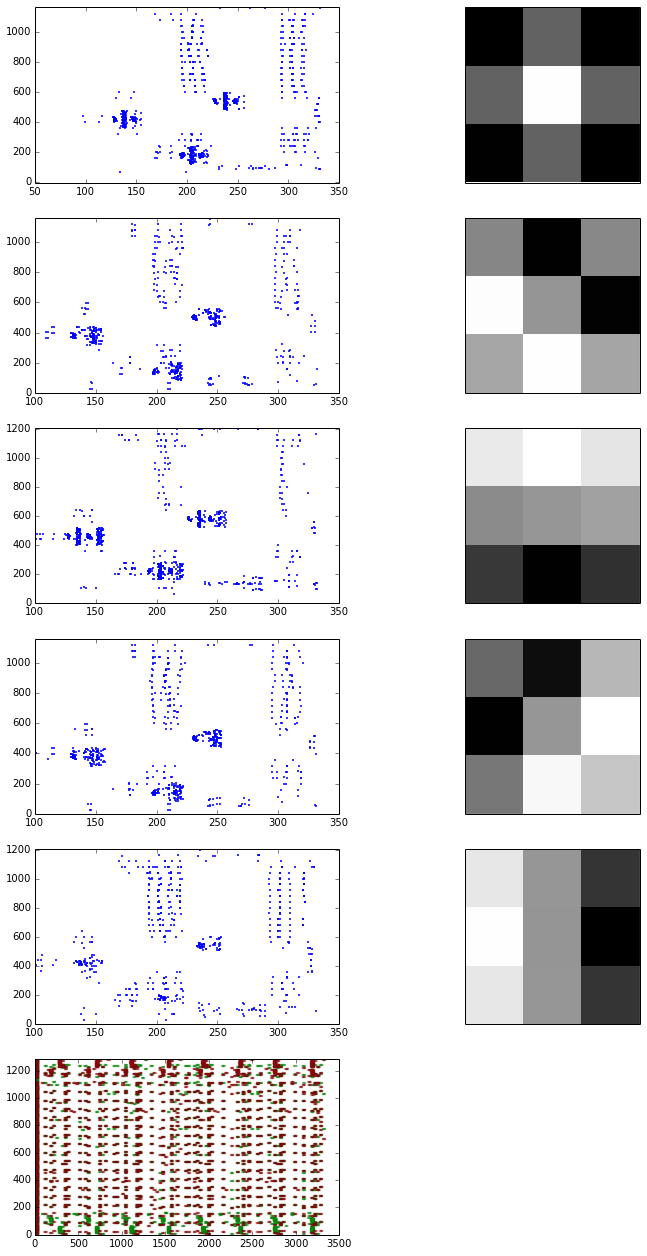

In [47]:
fig = plt.figure(figsize=(12, 22))
i = 0
for k in lgn_spks.keys():
    if k == 'cs':
        krn = retina.cs
    else:
        krn = retina.gab[k]

    i += 1
    ax = plt.subplot(6,2,i)
    plot_output_spikes(lgn_spks[k], color='b')

    i += 1
    ax = plt.subplot(6,2,i)
    my_imshow(ax, krn)

i += 1

ax = plt.subplot(6,2,i)
plot_spikes(spikes[:img_w*img_h], color=(0., 0.5, 0., 0.1))
plot_spikes(spikes[img_w*img_h:2*img_w*img_h], color=(0.5, 0., 0., 0.1))
plt.savefig('lgn_pres01.png', dpi=150)
plt.show()

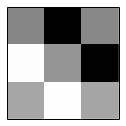

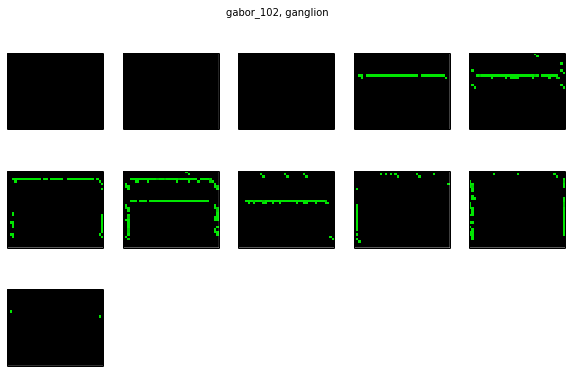

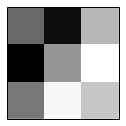

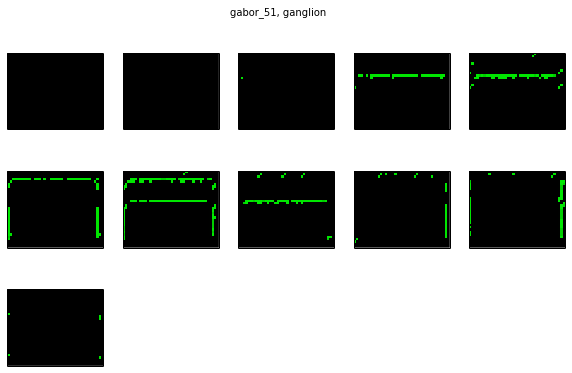

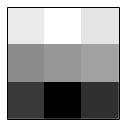

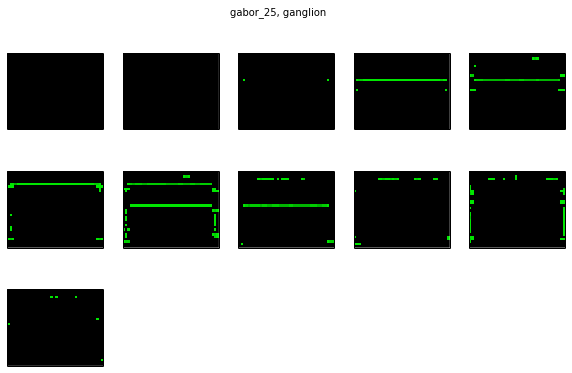

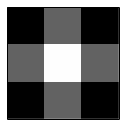

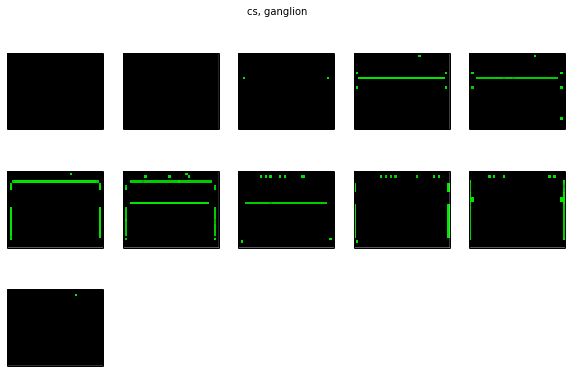

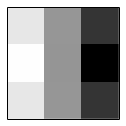

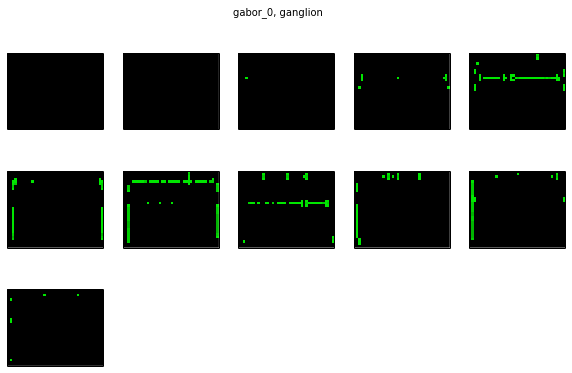

In [48]:
for p in out_spks['on'].keys():
    for t in out_spks['on'][p].keys():
        if t != 'ganglion':
            continue
            
#         fig = plt.figure()#figsize=(12, 8))
#         plot_output_spikes(out_spks['on'][p][t], color='g')
#         plot_output_spikes(out_spks['off'][p][t], color='r')
#         plt.suptitle("%s, %s"%(p, t))
#         plt.show()
        if p == 'cs':
            krn = retina.cs
        else:
            krn = retina.gab[p]
            
        fig = plt.figure(figsize=(2,2))
        ax = plt.subplot(1,1,1)
        my_imshow(ax, krn)
        plt.show()
        plot_out_spikes(out_spks['on'][p][t], 
                        out_spks['off'][p][t], 
                        img_w, img_h, 
                        on_time_ms, ftime_ms, thresh=25, 
                        title="%s, %s"%(p, t))

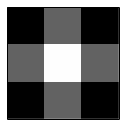

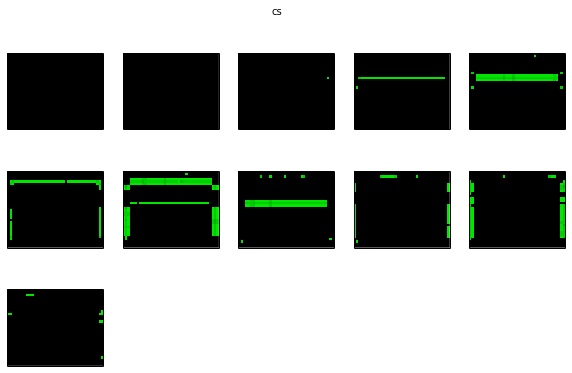

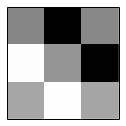

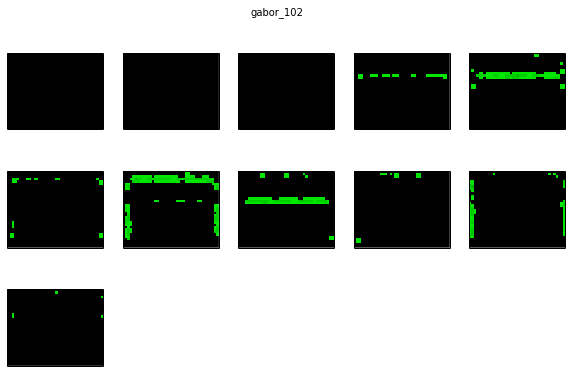

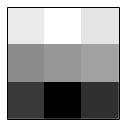

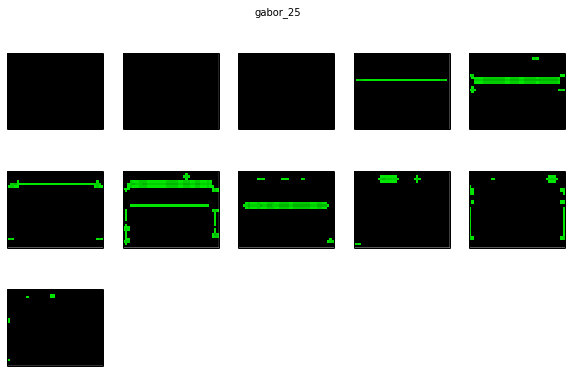

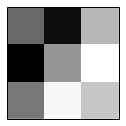

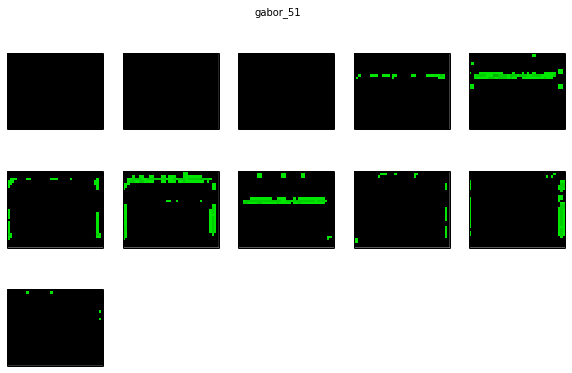

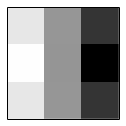

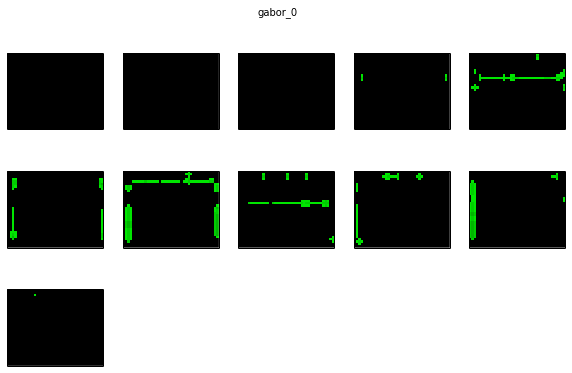

In [49]:
for k in lgn_spks.keys():
    if k == 'cs':
        krn = retina.cs
    else:
        krn = retina.gab[k]
    fig = plt.figure(figsize=(2,2))
    ax = plt.subplot(1,1,1)
    my_imshow(ax, krn)
    plt.show()
    plot_out_spikes(lgn_spks[k], [],
                    img_w, img_h, 
                    on_time_ms, ftime_ms, thresh=25, 
                    title="%s"%(k))